#### Install & Imports

In [1]:
!pip install -q flask-ngrok pyngrok flask

In [2]:
! pip install -q torch torchvision faiss-cpu pillow tqdm matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 51.2 MB/s eta 0:00:00


In [3]:
from flask import Flask, request, render_template_string
from flask_ngrok import run_with_ngrok
from werkzeug.utils import secure_filename
import os

In [4]:
import kagglehub
import shutil
import glob
import matplotlib.pyplot as plt

In [14]:
import torch
import numpy as np
import faiss
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from torchvision import models, transforms

In [31]:
import pandas as pd
from collections import defaultdict
import random
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import shutil

#### Dataset Load

In [5]:
# Download latest version
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fashion-product-images-small


In [6]:
destination_path = "/content/fashion_data"

if not os.path.exists(destination_path):
    shutil.copytree(path, destination_path)
    print("Dataset copied to:", destination_path)
else:
    print("Destination folder already exists.")

Dataset copied to: /content/fashion_data


In [7]:
!ls /content/fashion_data/myntradataset

images	styles.csv


In [8]:
print(f"The size of the dataset is:\n")
!du -sh fashion_data/myntradataset/

The size of the dataset is:

634M	fashion_data/myntradataset/


In [9]:
! ls fashion_data/myntradataset/images/ | wc -l

44441


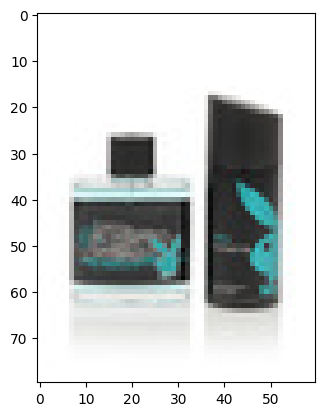

In [13]:
query_path = "fashion_data/myntradataset/images/32551.jpg"
query_img = Image.open(query_path)
plt.imshow(query_img)

#### HNSW Approch

In [57]:
class VisualProductRecommender:
    def __init__(self, img_dir, embedding_dim=512):
        self.img_dir = img_dir
        self.embedding_dim = embedding_dim
        self.product_embeddings = {}
        self.product_metadata = defaultdict(dict)
        self.product_ids = []

        # ResNet model initialization
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
        self.feature_extractor.eval()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.feature_extractor.to(self.device)

        # Image transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # FAISS HNSW index
        self.index = None
        self.id_to_index = {}
        self.index_to_id = {}

    def load_and_process_images(self):
        print("Processing images and extracting features...")

        image_files = [f for f in os.listdir(self.img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        embeddings_list = []

        for idx, filename in enumerate(tqdm(image_files, desc="Extracting features")):
            product_id = os.path.splitext(filename)[0]
            self.product_ids.append(product_id)
            img_path = os.path.join(self.img_dir, filename)

            # Load image and preprocess
            try :
              img = Image.open(img_path).convert("RGB")
              img_tensor = self.transform(img).unsqueeze(0).to(self.device)

            except :
              print(f"Error loading image: {img_path}")
              continue

            with torch.no_grad():
                features = self.feature_extractor(img_tensor).squeeze().cpu().numpy()

            self.product_embeddings[product_id] = features
            embeddings_list.append(features)

            # Map product_id to index and vice versa
            self.id_to_index[product_id] = idx
            self.index_to_id[idx] = product_id

            self.product_metadata[product_id] = {
                'filename': filename,
                'path': img_path
            }

        print(f"Processed {len(self.product_ids)} images total.")

        # Convert embeddings to numpy array and build FAISS HNSW index
        embeddings_array = np.array(embeddings_list).astype('float32')
        self._build_faiss_index(embeddings_array)


    def _build_faiss_index(self, embeddings_array):
        print("Building FAISS HNSW index...")

        # Create FAISS HNSW index
        self.index = faiss.IndexHNSWFlat(self.embedding_dim, 16)  # M=16 (connections per layer)
        self.index.hnsw.efConstruction = 100  # Higher values = more accurate but slower construction
        self.index.hnsw.efSearch = 50  # Higher values = more accurate but slower search

        # Add vectors to the index
        self.index.add(embeddings_array)

        print(f"FAISS HNSW index built with {len(embeddings_array)} vectors.")

    def find_similar_products(self, query_pid, k=5):
        """Find similar products using FAISS HNSW index"""
        if query_pid not in self.product_embeddings:
            return []

        # Get query embedding
        query_emb = self.product_embeddings[query_pid].reshape(1, -1).astype('float32')

        # Search for nearest neighbors
        distances, indices = self.index.search(query_emb, k + 1)  # +1 to include self

        # Process results (skip first result if it's the query itself)
        start_idx = 1 if indices[0][0] == self.id_to_index[query_pid] else 0
        results = []

        for i in range(start_idx, min(k + start_idx, len(indices[0]))):
            idx = indices[0][i]
            pid = self.index_to_id[idx]
            distance = distances[0][i]

            results.append({
                'product_id': pid,
                'distance': distance,
                'metadata': self.product_metadata[pid]
            })

        return results

    def find_similar_by_image(self, image_path, k=5):
        """Find similar products using an image that's not in the index"""
        # Load and preprocess image
        img = Image.open(image_path).convert("RGB")
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)

        # Extract features
        with torch.no_grad():
            features = self.feature_extractor(img_tensor).squeeze().cpu().numpy()

        # Convert to correct format for FAISS
        query_emb = features.reshape(1, -1).astype('float32')

        # Search for nearest neighbors
        distances, indices = self.index.search(query_emb, k)

        # Process results
        results = []
        for i in range(len(indices[0])):
            idx = indices[0][i]
            pid = self.index_to_id[idx]
            distance = distances[0][i]

            results.append({
                'product_id': pid,
                'distance': distance,
                'metadata': self.product_metadata[pid]
            })

        return results

    def visualize_results(self, query_path, results):
        """Visualize query image and similar products"""
        import matplotlib.pyplot as plt

        n = len(results) + 1
        fig, axes = plt.subplots(1, n, figsize=(n * 4, 5))

        # Display query image
        query_img = Image.open(query_path)
        axes[0].imshow(query_img)
        axes[0].set_title("Query Image")
        axes[0].axis('off')

        # Display similar images
        for i, rec in enumerate(results):
            img = Image.open(rec['metadata']['path'])
            axes[i+1].imshow(img)
            axes[i+1].set_title(f"Match {i+1}\nDistance: {rec['distance']:.4f}")
            axes[i+1].axis('off')

        plt.tight_layout()
        plt.show()

    def batch_index_images(self, img_dir, batch_size=100):
        """Process and index images in batches for large datasets"""
        image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i+batch_size]
            embeddings_list = []

            for idx, filename in enumerate(tqdm(batch_files, desc=f"Processing batch {i//batch_size + 1}")):
                product_id = os.path.splitext(filename)[0]
                global_idx = i + idx

                self.product_ids.append(product_id)
                img_path = os.path.join(img_dir, filename)

                # Process image
                img = Image.open(img_path).convert("RGB")
                img_tensor = self.transform(img).unsqueeze(0).to(self.device)

                with torch.no_grad():
                    features = self.feature_extractor(img_tensor).squeeze().cpu().numpy()

                self.product_embeddings[product_id] = features
                embeddings_list.append(features)

                # Update mappings
                self.id_to_index[product_id] = global_idx
                self.index_to_id[global_idx] = product_id

                self.product_metadata[product_id] = {
                    'filename': filename,
                    'path': img_path
                }

            # Add batch to index
            embeddings_array = np.array(embeddings_list).astype('float32')

            # For first batch, create the index
            if i == 0:
                self.index = faiss.IndexHNSWFlat(self.embedding_dim, 16)
                self.index.hnsw.efConstruction = 100
                self.index.hnsw.efSearch = 50

            # Add vectors to index
            self.index.add(embeddings_array)
            print(f"Added batch {i//batch_size + 1} to index, total vectors: {self.index.ntotal}")

    def save_index(self, filepath):
        """Save the FAISS index and metadata to disk"""
        # Save the FAISS index
        faiss.write_index(self.index, filepath)
        print(f"FAISS index saved to {filepath}")

        # Save metadata (mappings and product information)
        import pickle
        metadata_path = f"{filepath}_metadata.pkl"
        with open(metadata_path, 'wb') as f:
            metadata = {
                'id_to_index': self.id_to_index,
                'index_to_id': self.index_to_id,
                'product_metadata': self.product_metadata,
                'product_ids': self.product_ids,
                'product_embeddings': self.product_embeddings
            }
            pickle.dump(metadata, f)
        print(f"Metadata saved to {metadata_path}")

    def load_index(self, filepath):
        """Load the FAISS index and metadata from disk"""
        # Load the FAISS index
        self.index = faiss.read_index(filepath)
        print(f"Loaded FAISS index with {self.index.ntotal} vectors")

        # Load metadata
        import pickle
        metadata_path = f"{filepath}_metadata.pkl"
        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)
            self.id_to_index = metadata['id_to_index']
            self.index_to_id = metadata['index_to_id']
            self.product_metadata = metadata['product_metadata']
            self.product_ids = metadata['product_ids']
            self.product_embeddings = metadata['product_embeddings']
        print(f"Metadata loaded: {len(self.product_ids)} products")

In [58]:
# Load index in a new session
hnsw_recommender = VisualProductRecommender(img_dir='fashion_data/myntradataset/images/')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
hnsw_recommender.load_index('/content/product_index.faiss')

Loaded FAISS index with 40562 vectors
Metadata loaded: 40563 products


In [70]:
similar_products = hnsw_recommender.find_similar_products('51624', k=5)
for each in similar_products:
  each['metadata']['path'] = each['metadata']['path'].replace('/content/drive/MyDrive/MLBD/Project/data/', '/content/fashion_data/myntradataset/')

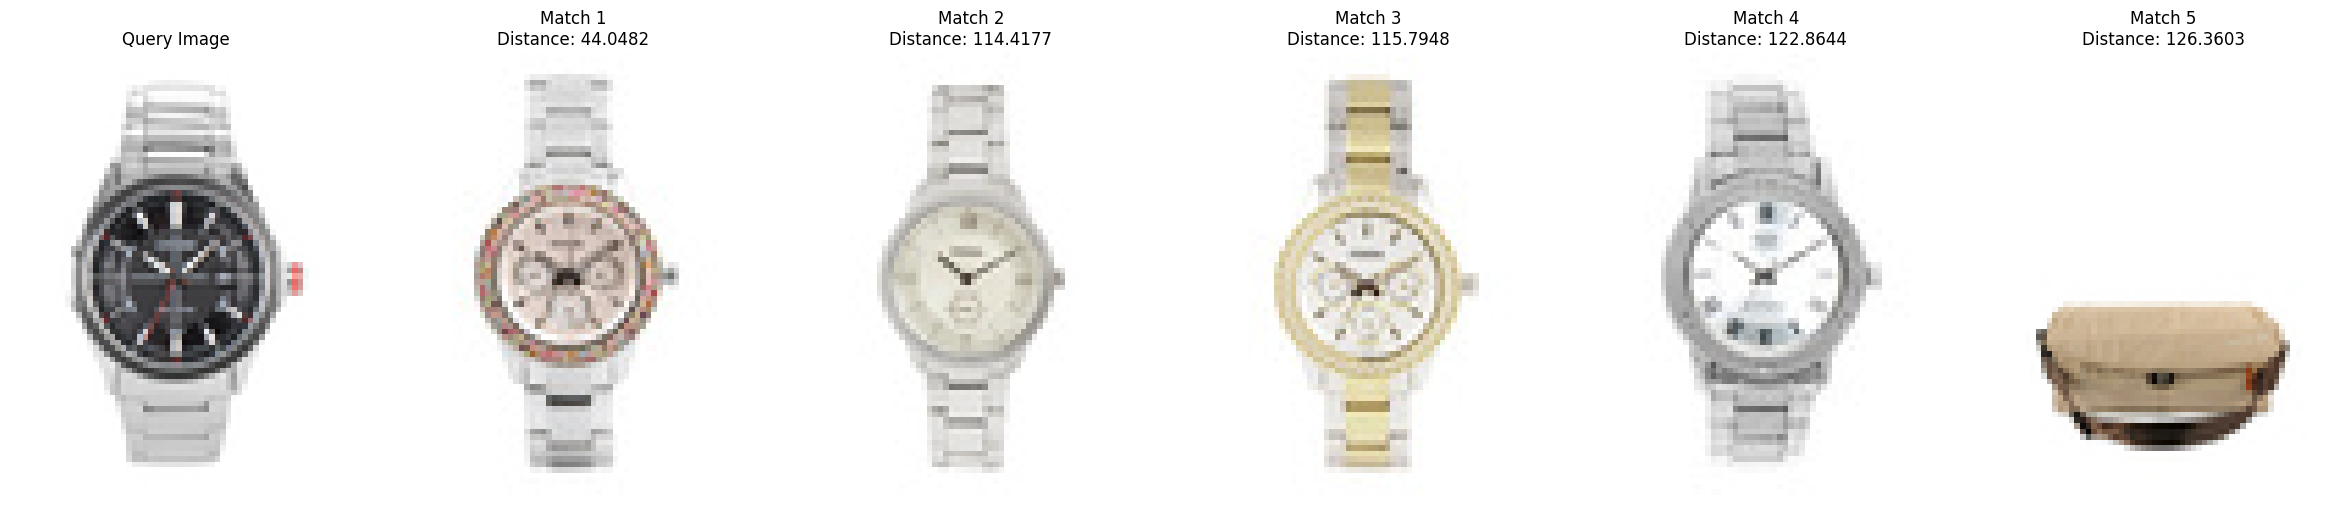

In [71]:
query_path = '/content/fashion_data/myntradataset/images/33914.jpg'
hnsw_recommender.visualize_results(query_path, similar_products)

In [66]:
similar_products = hnsw_recommender.find_similar_products('49019', k=5)
for each in similar_products:
  each['metadata']['path'] = each['metadata']['path'].replace('/content/drive/MyDrive/MLBD/Project/data/', '/content/fashion_data/myntradataset/')

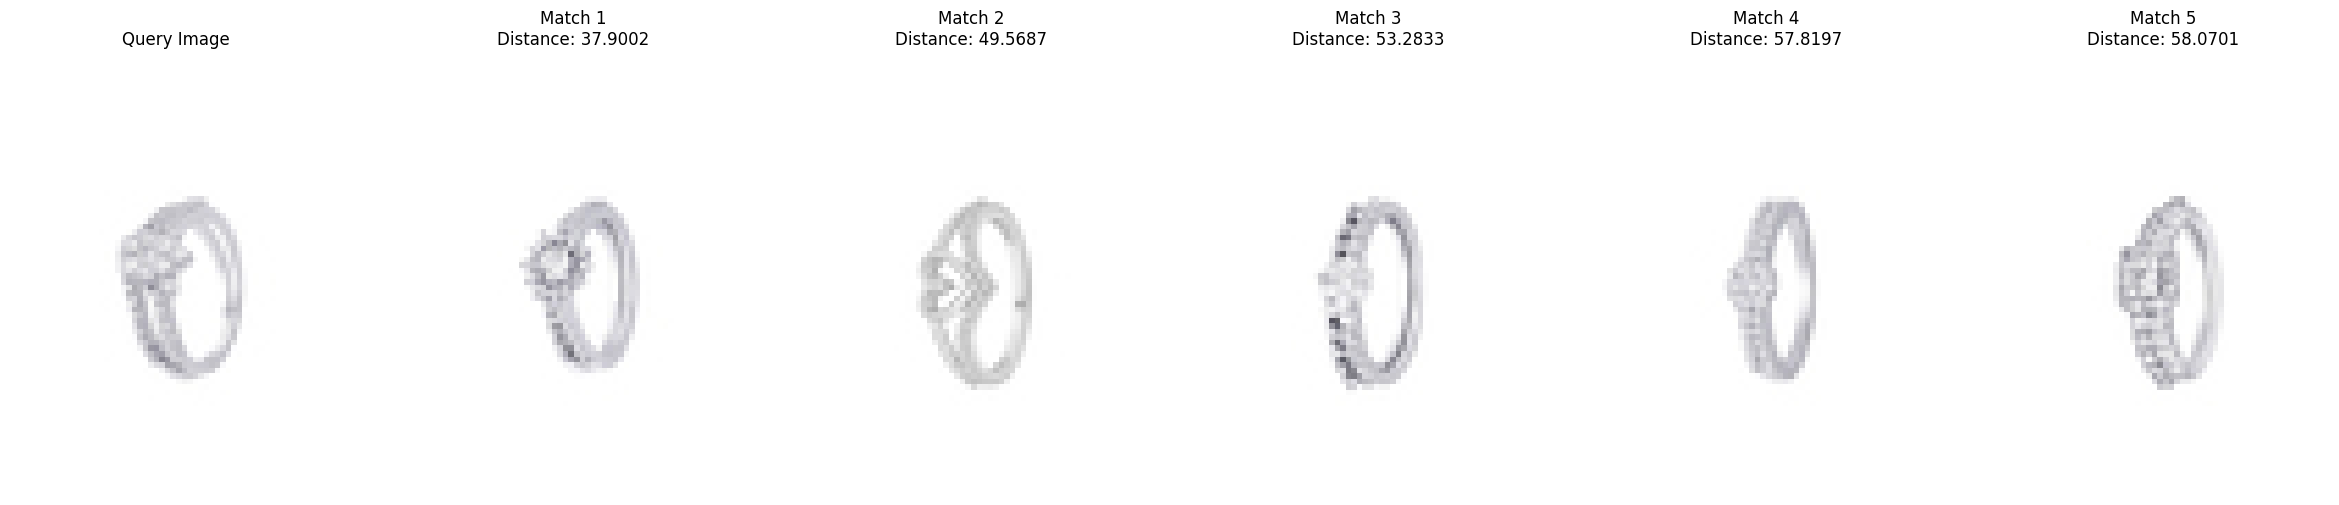

In [67]:
query_path = '/content/fashion_data/myntradataset/images/49019.jpg'
hnsw_recommender.visualize_results(query_path, similar_products)

#### LSH Approch

In [38]:
class VisualProductRecommender_LSH:
  def __init__(self, img_dir, embedding_dim=512, n_clusters=100, n_hash_tables=5, hash_size=10, seed=143):
    self.seed = seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    self.img_dir = img_dir
    self.embedding_dim = embedding_dim
    self.product_embeddings = {}
    self.product_metadata = defaultdict(dict)
    self.product_ids = []
    self.n_clusters = n_clusters
    self.n_hash_tables = n_hash_tables
    self.hash_size = hash_size

    # ResNet50 model initialisation
    resnet = models.resnet18(pretrained=True)
    self.feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
    self.feature_extractor.eval()
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.feature_extractor.to(self.device)

    # Image transform
    self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    # LSH components
    self.hash_tables = [defaultdict(list) for _ in range(n_hash_tables)]
    self.random_planes = [np.random.randn(embedding_dim, hash_size) for _ in range(n_hash_tables)]

    # Clustering
    self.cluster_model = KMeans(n_clusters=n_clusters, random_state=143)
    self.product_clusters = {}

    # Graph
    self.product_graph = None
    self.pagerank_scores = {}
    self.cluster_pagerank = {}

  def _save_artifacts(self, save_dir="/content/drive/MyDrive/MLBD/Project/data/artifacts/"):
      os.makedirs(save_dir, exist_ok=True)

      with open(os.path.join(save_dir, 'random_planes.pkl'), 'wb') as f:
          pickle.dump(self.random_planes, f)

      with open(os.path.join(save_dir, 'hash_tables.pkl'), 'wb') as f:
          pickle.dump(self.hash_tables, f)

      with open(os.path.join(save_dir, 'product_embeddings.pkl'), 'wb') as f:
          pickle.dump(self.product_embeddings, f)

      with open(os.path.join(save_dir, 'product_metadata.pkl'), 'wb') as f:
          pickle.dump(self.product_metadata, f)

      with open(os.path.join(save_dir, 'product_clusters.pkl'), 'wb') as f:
          pickle.dump(self.product_clusters, f)

      with open(os.path.join(save_dir, 'pagerank_scores.pkl'), 'wb') as f:
          pickle.dump(self.pagerank_scores, f)

      with open(os.path.join(save_dir, 'cluster_pagerank.pkl'), 'wb') as f:
          pickle.dump(self.cluster_pagerank, f)

      print("Artifacts saved.")

  def _load_artifacts(self, save_dir="/content/drive/MyDrive/MLBD/Project/data/artifacts/"):
      with open(os.path.join(save_dir, 'random_planes.pkl'), 'rb') as f:
          self.random_planes = pickle.load(f)

      with open(os.path.join(save_dir, 'combined_hash_tables.pkl'), 'rb') as f:
          self.hash_tables = pickle.load(f)

      with open(os.path.join(save_dir, 'combined_embeddings.pkl'), 'rb') as f:
          self.product_embeddings = pickle.load(f)
          self.product_ids = list(self.product_embeddings.keys())

      with open(os.path.join(save_dir, 'combined_product_metadata.pkl'), 'rb') as f:
          self.product_metadata = pickle.load(f)

      with open(os.path.join(save_dir, 'product_clusters.pkl'), 'rb') as f:
          self.product_clusters = pickle.load(f)

      with open(os.path.join(save_dir, 'pagerank_scores.pkl'), 'rb') as f:
          self.pagerank_scores = pickle.load(f)

      with open(os.path.join(save_dir, 'cluster_pagerank.pkl'), 'rb') as f:
          self.cluster_pagerank = pickle.load(f)

      with open(os.path.join(save_dir, 'mapping_dict.pkl'), 'rb') as f:
        global mapping_dict
        mapping_dict = pickle.load(f)

      print("Artifacts loaded.")

  def load_and_process_images(self):
        print("Processing images and extracting features...")

        image_files = [f for f in os.listdir(self.img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Taking a sample of first 10 images
        # image_files = image_files[:10]

        for filename in tqdm(image_files, desc="Extracting features"):
            product_id = os.path.splitext(filename)[0]
            self.product_ids.append(product_id)
            img_path = os.path.join(self.img_dir, filename)

            # Load image and preprocess
            img = Image.open(img_path).convert("RGB")
            img_tensor = self.transform(img).unsqueeze(0).to(self.device)

            with torch.no_grad():
                features = self.feature_extractor(img_tensor).squeeze().cpu().numpy()
            features = features / np.linalg.norm(features)
            self.product_embeddings[product_id] = features
            self.product_metadata[product_id] = {
                'filename': filename,
                'path': img_path,
                'category': mapping_dict.get(product_id)
            }

        print(f"Processed {len(self.product_ids)} images total.")

        self._build_lsh_tables()
        self._cluster_products()
        self._build_product_graph()
        self._compute_pagerank()
        self._save_artifacts()

  def _build_lsh_tables(self):
    """

    """
    print("Building LSH tables...")
    for pid in self.product_ids:
        emb = self.product_embeddings[pid]
        for i in range(self.n_hash_tables):
            projections = np.dot(emb, self.random_planes[i])
            hash_code = ''.join(['1' if x > 0 else '0' for x in projections])
            self.hash_tables[i][hash_code].append(pid)
    print("LSH tables are built")
    print(f"Below are the final hask tables: {self.hash_tables}")

  def _cluster_products(self):
        print("Clustering products...")
        embeddings = np.array([self.product_embeddings[pid] for pid in self.product_ids])
        cluster_labels = self.cluster_model.fit_predict(embeddings)
        for i, pid in enumerate(self.product_ids):
            self.product_clusters[pid] = cluster_labels[i]
            self.product_metadata[pid]['cluster'] = int(cluster_labels[i])

  def _build_product_graph(self):
        print("Building product graph...")
        G = nx.DiGraph()
        for pid in self.product_ids:
            G.add_node(pid, embedding=self.product_embeddings[pid])

        for pid1 in self.product_ids:
            cluster = self.product_clusters[pid1]
            candidates = [pid for pid in self.product_ids if self.product_clusters[pid] == cluster and pid != pid1]
            for pid2 in random.sample(candidates, min(5, len(candidates))):
                sim = cosine_similarity([self.product_embeddings[pid1]], [self.product_embeddings[pid2]])[0][0]
                if sim > 0.5:
                    G.add_edge(pid1, pid2, weight=sim)

        self.product_graph = G
        print("Product graph is built")
        # self._visualize_product_graph(self.product_graph, num_nodes=10)


  def _visualize_product_graph(self, product_graph, num_nodes=10):
      """
      Visualize a subgraph of the product graph with up to `num_nodes` nodes.
      """
      print(f"Visualizing a subgraph with up to {num_nodes} nodes...")

      # Extract a subgraph with the first `num_nodes` nodes (for clarity)
      nodes_subset = list(product_graph.nodes)[:num_nodes]
      subgraph = product_graph.subgraph(nodes_subset)

      pos = nx.spring_layout(subgraph, seed=42)  # Layout algorithm
      edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges]

      plt.figure(figsize=(12, 8))
      nx.draw_networkx_nodes(subgraph, pos, node_size=300, node_color='skyblue', alpha=0.9)
      nx.draw_networkx_edges(subgraph, pos, width=edge_weights, alpha=0.5)
      nx.draw_networkx_labels(subgraph, pos, font_size=10)

      plt.title("Product Similarity Graph (Subgraph)")
      plt.axis('off')
      plt.show()

  def _compute_pagerank(self):

        print("Computing PageRank scores...")
        self.pagerank_scores = nx.pagerank(self.product_graph, alpha=0.85)

        for cluster_id in range(self.n_clusters):
            personalization = {}
            for pid in self.product_ids:
                personalization[pid] = 1.0 if self.product_clusters[pid] == cluster_id else 0.1

            total = sum(personalization.values())
            personalization = {k: v / total for k, v in personalization.items()}
            self.cluster_pagerank[cluster_id] = nx.pagerank(self.product_graph, alpha=0.85, personalization=personalization)

  def find_similar_via_lsh(self, query_pid, k=5):
        if query_pid not in self.product_embeddings:
            return []

        emb = self.product_embeddings[query_pid]
        candidates = set()

        for i in range(self.n_hash_tables):
            projections = np.dot(emb, self.random_planes[i])
            hash_code = ''.join(['1' if x > 0 else '0' for x in projections])
            bucket = self.hash_tables[i].get(hash_code, [])
            candidates.update(pid for pid in bucket if pid != query_pid)

        # if len(candidates) < k:
        #     cluster = self.product_clusters[query_pid]
        #     fallback = [pid for pid in self.product_ids if self.product_clusters[pid] == cluster and pid != query_pid]
        #     candidates.update(random.sample(fallback, min(k - len(candidates), len(fallback))))

        similarities = []
        for cid in candidates:
            sim = cosine_similarity([emb], [self.product_embeddings[cid]])[0][0]
            similarities.append((cid, sim))

        similarities.sort(key=lambda x: x[1], reverse=True)
        results = []
        for pid, sim in similarities[:k]:
            results.append({
                'product_id': pid,
                'similarity': sim,
                # 'pagerank': self.pagerank_scores[pid],
                'metadata': self.product_metadata[pid]
            })

        return results

  def setup_for_inference(self, artifact_path="/content/drive/MyDrive/MLBD/Project/data/artifacts/"):
      self._load_artifacts(artifact_path)

  def get_recommendations(self, query_pid, k=5, use_topic_pagerank=True):
            if query_pid not in self.product_embeddings:
                return []

            candidates = self.find_similar_via_lsh(query_pid, k=k*2)
            # cluster = self.product_clusters[query_pid]
            # pagerank_dict = self.cluster_pagerank[cluster] if use_topic_pagerank else self.pagerank_scores

            for item in candidates:
                pid = item['product_id']
                score = 1 * item['similarity']
                # + 0.3 * pagerank_dict[pid]
                item['combined_score'] = score

            candidates.sort(key=lambda x: x['combined_score'], reverse=True)
            return candidates[:k]

  def metrics(self, query_id, recommendations):
    query_category = mapping_dict.get(query_id)
    rec_categories = [mapping_dict.get(rec['product_id']) for rec in recommendations]
    precision = sum(1 for rec in recommendations if mapping_dict.get(rec['product_id']) == query_category) / len(recommendations)
    # recall = sum(1 for rec in recommendations if mapping_dict.get(rec['product_id']) == query_category) / len([v for v in mapping_dict.values() if v == query_category])
    recall = 1 if any(mapping_dict.get(rec['product_id']) == query_category for rec in recommendations) else 0
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
    return precision, recall, f1_score


  def visualize_recommendations(self, query_pid, recommendations):
        precision, recall, f1 = self.metrics(query_pid, recommendations)
        print(f"\nEvaluation Metrics:")
        print(f"Precision: {precision:.2f}")
        print(f"Recall:    {recall:.2f}")
        print(f"F1 Score:  {f1:.2f}\n")
        n = len(recommendations) + 1
        fig, axes = plt.subplots(1, n, figsize=(n * 4, 5))
        # query_img = Image.open(self.product_metadata[query_pid]['path'])
        query_path = self.product_metadata[query_pid]['path'].replace('/content/drive/MyDrive/MLBD/Project/data/', '/content/fashion_data/myntradataset/')
        query_img = Image.open(query_path)
        axes[0].imshow(query_img)
        # axes[0].set_title(f"Query\n{query_pid}\nCluster: {self.product_clusters[query_pid]}")
        axes[0].set_title(f"Query\n{query_pid}\n{self.product_metadata[query_pid]['category']}")
        axes[0].axis('off')

        for i, rec in enumerate(recommendations):
            img = Image.open(rec['metadata']['path'])
            axes[i+1].imshow(img)
            axes[i+1].set_title(f"Recc\n{rec['product_id']}\nSim: {rec['similarity']:.2f}")
            # axes[i+1].set_title(f"Recc\n{rec['product_id']}\nSim: {rec['similarity']:.2f}\nPR: {rec['pagerank']:.2f}")
            axes[i+1].axis('off')

        plt.tight_layout()
        plt.show()

In [18]:
# os.makedirs("/content/drive/MyDrive/MLBD/Project/data/artifacts/")

In [19]:
# import glob
# glob.glob("/content/drive/MyDrive/MLBD/Project/data/artifacts/*")

In [44]:
data_dir = "/content/drive/MyDrive/MLBD/Project/data/images/"
lsh_recommender = VisualProductRecommender_LSH(data_dir)

In [45]:
lsh_recommender.setup_for_inference(artifact_path = "/content/drive/MyDrive/MLBD/Project/data/artifacts")

Artifacts loaded.


In [46]:
similar_products_lsh = lsh_recommender.get_recommendations(query_pid='8808', k=2)
similar_products_lsh

[{'product_id': '7174',
  'similarity': np.float32(1.0000002),
  'metadata': {'filename': '7174.jpg',
   'path': '/content/drive/MyDrive/MLBD/Project/data/images/7174.jpg',
   'category': 'Shirts',
   'cluster': 97},
  'combined_score': np.float32(1.0000002)},
 {'product_id': '9588',
  'similarity': np.float32(0.96326935),
  'metadata': {'filename': '9588.jpg',
   'path': '/content/drive/MyDrive/MLBD/Project/data/images/9588.jpg',
   'category': 'Shirts',
   'cluster': 97},
  'combined_score': np.float32(0.96326935)}]

In [47]:
for each in similar_products_lsh:
  each['metadata']['path'] = each['metadata']['path'].replace('/content/drive/MyDrive/MLBD/Project/data/', '/content/fashion_data/myntradataset/')
similar_products_lsh

[{'product_id': '7174',
  'similarity': np.float32(1.0000002),
  'metadata': {'filename': '7174.jpg',
   'path': '/content/fashion_data/myntradataset/images/7174.jpg',
   'category': 'Shirts',
   'cluster': 97},
  'combined_score': np.float32(1.0000002)},
 {'product_id': '9588',
  'similarity': np.float32(0.96326935),
  'metadata': {'filename': '9588.jpg',
   'path': '/content/fashion_data/myntradataset/images/9588.jpg',
   'category': 'Shirts',
   'cluster': 97},
  'combined_score': np.float32(0.96326935)}]


Evaluation Metrics:
Precision: 1.00
Recall:    1.00
F1 Score:  1.00



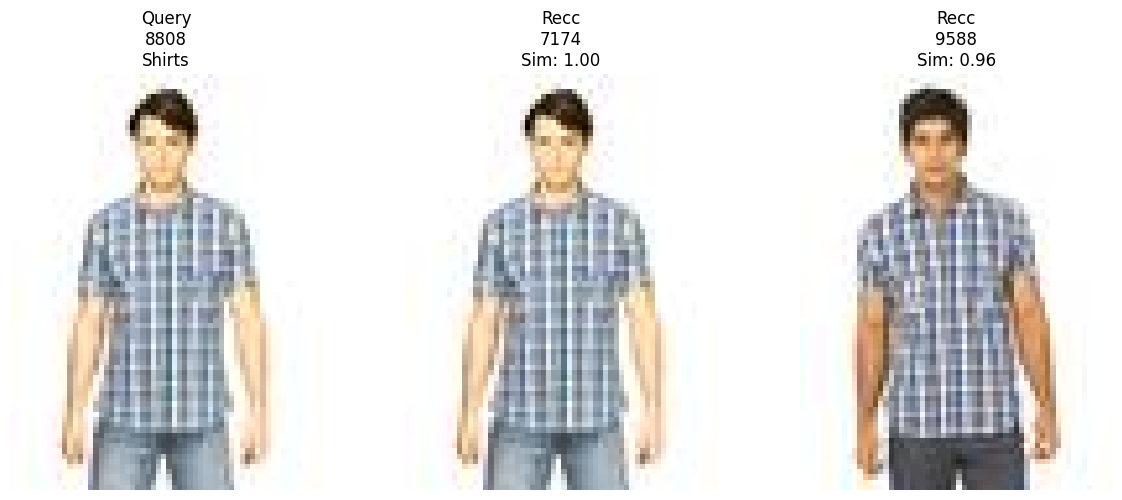

In [48]:
lsh_recommender.visualize_recommendations('8808', similar_products_lsh)  #10017

In [ ]:
# Average Precision: 0.74
# Average Recall: 0.91
# Average F1 Score: 0.79 # Select 200 random product_ids

#### Authenticate ngrok

In [33]:
token = "2vx7a6ZIEf417RSZO3gUptfvcfq_5Xiv2VZwB2Kc8e8oUUZ6P"
from pyngrok import ngrok

# Replace YOUR_AUTHTOKEN_HERE with your actual token (inside quotes!)
ngrok.set_auth_token(token)

#### Flask App

##### HTML

In [52]:
HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Product Recommender</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background: linear-gradient(to right, #f7f8fc, #e0eafc);
            margin: 0;
            padding: 0;
            overflow-x: hidden;
        }
        .container {
            max-width: 900px;
            margin: auto;
            padding: 20px;
            text-align: center;
        }
        h1 {
            color: #333;
            margin-bottom: 30px;
        }
        form {
            margin-bottom: 40px;
        }
        input[type="text"] {
            padding: 10px;
            width: 300px;
            border: 1px solid #ccc;
            border-radius: 8px;
            margin-bottom: 20px;
        }
        .btn-group {
            margin-top: 10px;
        }
        .btn {
            padding: 10px 20px;
            margin: 0 10px;
            background-color: #4CAF50;
            color: white;
            border: none;
            border-radius: 8px;
            cursor: pointer;
            font-weight: bold;
        }
        .btn:hover {
            background-color: #45a049;
        }
        h2 {
            color: #444;
            margin-top: 40px;
        }
        .image-container {
            display: flex;
            flex-wrap: wrap;
            justify-content: center;
            gap: 25px;
            margin-top: 20px;
        }
        .recommended-box {
            text-align: center;
            background-color: #ffffffee;
            padding: 10px;
            border-radius: 12px;
            box-shadow: 0 4px 8px rgba(0,0,0,0.1);
            width: 180px;
        }
        .image {
            width: 160px;
            height: auto;
            border-radius: 8px;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Fashion Product Recommender</h1>
        <form action="/recommend" method="post">
            <input type="text" name="product_id" placeholder="Enter Product ID" required>
            <div class="btn-group">
                <button class="btn" type="submit" name="algo" value="lsh">LSH Recommend</button>
                <button class="btn" type="submit" name="algo" value="hnsw">HNSW Recommend</button>
            </div>
        </form>

        {% if query_image %}
        <h2>Query Image</h2>
        <div class="image-container">
            <div class="recommended-box">
                <img src="{{ query_image }}" alt="Query Image" class="image">
                <p><strong>Query Product</strong></p>
            </div>
        </div>
        {% endif %}

        {% if recommended_images %}
        <h2>Recommended Images</h2>
        <div class="image-container">
            {% for image in recommended_images %}
                <div class="recommended-box">
                    <img src="{{ image.url }}" alt="Recommended" class="image">
                    <p>Product ID: {{ image.product_id }}</p>
                </div>
            {% endfor %}
        </div>
        {% endif %}
    </div>
</body>
</html>
"""

##### App

In [68]:
app = Flask(__name__)

# Folder to save uploaded images (for demo)
UPLOAD_FOLDER = '/content/uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER


# Sample recommendation handler
@app.route('/', methods=['GET'])
def home():
    return render_template_string(HTML_TEMPLATE)

@app.route('/recommend', methods=['POST'])
def recommend():
    product_id = request.form.get('product_id')
    method = request.form.get('algo')  # Get which button was clicked
    query_image_path = f'/images/{product_id}.jpg'  #

    if method == "lsh":
        print(f"Running LSH-based recommendation for product ID: {product_id}")
        recommendations = lsh_recommender.get_recommendations(query_pid=product_id, k=3)
        for each in recommendations:
          each['metadata']['path'] = each['metadata']['path'].replace('/content/drive/MyDrive/MLBD/Project/data/', '/content/fashion_data/myntradataset/')

    elif method == "hnsw":
        print(f"Running HNSW-based recommendation for product ID: {product_id}")
        recommendations = hnsw_recommender.find_similar_products(product_id, k=3)
        for each in recommendations:
          each['metadata']['path'] = each['metadata']['path'].replace('/content/drive/MyDrive/MLBD/Project/data/', '/content/fashion_data/myntradataset/')

    else:
        recommendations = []
    # Extract query image and recommended images
    if recommendations:
        recommended_images = [
            {
                "filename": rec["metadata"]["filename"],
                "url": f"/images/{rec['metadata']['filename']}",
                "product_id": rec["product_id"],

            }
            for rec in recommendations
        ]
    else:
        recommended_images = [
            {"url" : "https://i.imgur.com/ExdKOOz.png","product_id" :"DummyId"},
            {"url":"https://i.imgur.com/ExdKOOz.png","product_id" :"DummyId"},
            {"url":"https://i.imgur.com/ExdKOOz.png","product_id" :"DummyId"},
        ]
    print(recommended_images)
    return render_template_string(
        HTML_TEMPLATE,
        query_id=product_id,
        query_image=query_image_path,
        recommended_images=recommended_images
    )

from flask import send_from_directory

@app.route('/images/<path:filename>')
def serve_image(filename):
    return send_from_directory('/content/fashion_data/myntradataset/images', filename)

In [69]:
# Start ngrok tunnel
public_url = ngrok.connect(5000)
print(" * Ngrok Tunnel URL:", public_url)


# # Start Flask app
app.run(port=5000)

 * Ngrok Tunnel URL: NgrokTunnel: "https://6ac6-34-75-35-35.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:01] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:02] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:06] "POST /recommend HTTP/1.1" 200 -


Running HNSW-based recommendation for product ID: 51624
[{'filename': '51623.jpg', 'url': '/images/51623.jpg', 'product_id': '51623'}, {'filename': '51622.jpg', 'url': '/images/51622.jpg', 'product_id': '51622'}, {'filename': '51630.jpg', 'url': '/images/51630.jpg', 'product_id': '51630'}]


INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:07] "GET /images/51622.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:07] "GET /images/51630.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:07] "GET /images/51624.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:07] "GET /images/51623.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:16] "POST /recommend HTTP/1.1" 200 -


Running HNSW-based recommendation for product ID: 49019
[{'filename': '49025.jpg', 'url': '/images/49025.jpg', 'product_id': '49025'}, {'filename': '48925.jpg', 'url': '/images/48925.jpg', 'product_id': '48925'}, {'filename': '49012.jpg', 'url': '/images/49012.jpg', 'product_id': '49012'}]


INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:17] "GET /images/49019.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:17] "GET /images/48925.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:17] "GET /images/49025.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:17] "GET /images/49012.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:24] "POST /recommend HTTP/1.1" 200 -


Running HNSW-based recommendation for product ID: 8808
[{'filename': '7174.jpg', 'url': '/images/7174.jpg', 'product_id': '7174'}, {'filename': '9651.jpg', 'url': '/images/9651.jpg', 'product_id': '9651'}, {'filename': '8743.jpg', 'url': '/images/8743.jpg', 'product_id': '8743'}]


INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:25] "GET /images/8808.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:25] "GET /images/7174.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:25] "GET /images/9651.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:25] "GET /images/8743.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:36] "POST /recommend HTTP/1.1" 200 -


Running HNSW-based recommendation for product ID: 10017
[{'filename': '11518.jpg', 'url': '/images/11518.jpg', 'product_id': '11518'}, {'filename': '19528.jpg', 'url': '/images/19528.jpg', 'product_id': '19528'}, {'filename': '16497.jpg', 'url': '/images/16497.jpg', 'product_id': '16497'}]


INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:36] "GET /images/10017.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:36] "GET /images/11518.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:36] "GET /images/19528.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Apr/2025 16:22:36] "GET /images/16497.jpg HTTP/1.1" 200 -
